In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
class_names = ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '5', '6', '7', '8', '9']

In [3]:
labels_csv = pd.read_csv("labels.csv")
labels_csv.tail()

,Class,Label,Devanagari label,Phonetic,Type
41,41,patalosaw,स,sa,CONSONANT
42,42,ha,ह,ha,CONSONANT
43,43,ksha,क्ष,kṣa,CONSONANT
44,44,tra,त्र,tra,CONSONANT
45,45,gya,ज्ञ,jña,CONSONANT


In [4]:
model = tf.keras.models.load_model('nepali_ocr_model.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 32, 32, 1)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 64)        18496     
                                                      

1/1 [==============================] - 0s 209ms/step
This image most likely belongs to ब with a 99.18 percent confidence.


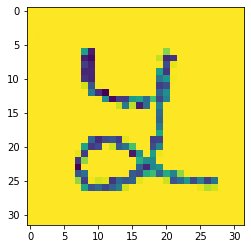

In [16]:
try_img = tf.keras.utils.load_img(
    "Assets/pics/5.jpeg", 
    target_size=(32, 32),
    color_mode='grayscale',
)
plt.imshow(try_img)

img_array = tf.keras.utils.img_to_array(try_img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_name = int(class_names[np.argmax(score)])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
)

In [25]:
def prediction(src):
    img = cv2.imread(src, 0)

    blur = cv2.GaussianBlur(img,(5,5),0)
    ret,img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

    plt.imshow(img)
    plt.show()

    img = cv2.resize(img, (32, 32))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.erode(img, (3, 3), 1)
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    class_name = int(class_names[np.argmax(score)])
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
    )
    devanagari_label = labels_csv.loc[class_name, 'Devanagari label']
    success = 100 * np.max(score)
    
    return devanagari_label, success

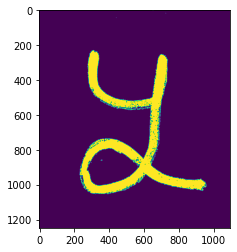

1/1 [==============================] - 0s 383ms/step
This image most likely belongs to ५ with a 99.86 percent confidence.


('५', 99.86181259155273)

In [26]:
prediction("Assets/pics/5.jpeg")

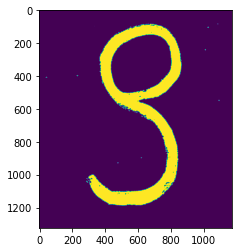

1/1 [==============================] - 0s 287ms/step
This image most likely belongs to ९ with a 99.97 percent confidence.


('९', 99.96575117111206)

In [27]:
prediction("Assets/pics/9.jpeg")

In [14]:
def borders(here_img, thresh, bthresh=0.092):
    shape = here_img.shape
    #check = int(115 * size[0] / 600)
    #check = int(55 * size[0] / 600)
    check= int(bthresh*shape[0])
    image = here_img[:]
    top, bottom = 0, shape[0] - 1
    #plt.imshow(image)
    #plt.show()
    

    #find the background color for empty column
    bg = np.repeat(thresh, shape[1])
    count = 0
    for row in range(1, shape[0]):
        if  (np.equal(bg, image[row]).any()) == True:
            #print(count)
            count += 1
        else:
            count = 0
        if count >= check:
            top = row - check
            break
    

    bg = np.repeat(thresh, shape[1])
    count = 0
    rows = np.arange(1, shape[0])
    #print(rows)
    for row in rows[::-1]:
        if  (np.equal(bg, image[row]).any()) == True:
            count += 1
        else:
            count = 0
        if count >= check:
            bottom = row + count
            break

    d1 = (top - 2) >= 0 
    d2 = (bottom + 2) < shape[0]
    d = d1 and d2
    if(d):
        b = 2
    else:
        b = 0
    
    return (top, bottom, b)


def preprocess(bgr_img):#gray image   
    blur = cv2.GaussianBlur(bgr_img,(5,5),0)
    ret,th_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

    rows, cols = th_img.shape
    bg_test = np.array([th_img[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_color = 255
    else:
        text_color = 0
    
    tb = borders(th_img, text_color)
    lr = borders(th_img.T, text_color)
    dummy = int(np.average((tb[2], lr[2]))) + 2
    template = th_img[tb[0]+dummy:tb[1]-dummy, lr[0]+dummy:lr[1]-dummy]
    
    plt.imshow(template)
    plt.show()
    return (template, tb, lr)


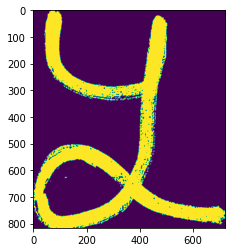

In [15]:
img = cv2.imread("Assets/pics/5.jpeg", 0)
prepimg, tb, lr = preprocess(img)

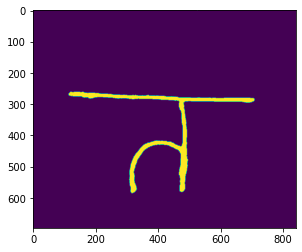

1/1 [==============================] - 0s 416ms/step
This image most likely belongs to ७ with a 59.01 percent confidence.


('७', 59.01322364807129)

In [29]:
prediction("Assets/sohel/ta.jpg")

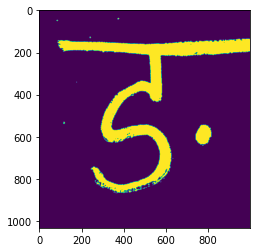

1/1 [==============================] - 0s 351ms/step
This image most likely belongs to ङ with a 99.59 percent confidence.


('ङ', 99.5888888835907)

In [31]:
prediction("Assets/pics/anga.jpeg")